In [235]:
import numpy as np
import matplotlib.pyplot as plt
from numba import *
import time

In [236]:
# Discretization parameters
# num_bins_angle = round(1.25*75) 
# num_bins_ang_vel = round(1.25*75) 
# num_bins_action = round(1.25*10)

num_bins_angle = 75 
num_bins_ang_vel = 75
num_bins_action = 10

angle_range = (-np.pi, np.pi)
ang_vel_range = (-8, 8)
action_range = (-2, 2)

num_episodes = 100000
num_runs = 20
max_steps = 200
alpha = 0.1
gamma = 1.0
# epsilon = 0.05
epsilon = 0

In [237]:
@njit
def discretize(value, bins):
    # min_val, max_val = value_range
    # bin_width = (max_val - min_val) / bins
    # bin_idx = int((value - min_val) / bin_width)
    # return min(max(bin_idx, 0), bins - 1)
    return np.digitize(value, bins) - 1

In [238]:
@njit
def discretize_state(state, angle_bins, angle_vel_bins):
    w, w_dot = state
    w_normalized = ((w + np.pi) % (2 * np.pi)) - np.pi
    w_dot_clipped = max(min(w_dot, ang_vel_range[1]), ang_vel_range[0])
    b_w = discretize(w_normalized, angle_bins)
    b_w_dot = discretize(w_dot_clipped, angle_vel_bins)
    return (b_w, b_w_dot)

In [239]:
@njit
def next_values(state, action):
    """
    Simulate the pendulum's next state and reward based on the dynamics.
    """
    w, w_dot = state
    torque = np.linspace(action_range[0], action_range[1], num_bins_action)[action]

    # Dynamics
    w_ddot = 3 * 10 / (2 * 1) * np.sin(w) + 3 * torque / (1 * 1**2)
    w_dot_new = max(min(w_dot + w_ddot * 0.05, ang_vel_range[1]), ang_vel_range[0])
    w_new = w + w_dot_new * 0.05
    w_new = ((w_new + np.pi) % (2 * np.pi)) - np.pi
    # Reward calculation
    # w_normalized = ((w + np.pi) % (2 * np.pi)) - np.pi
    reward = -(w**2 + 0.1 * w_dot**2 + 0.001 * torque**2)

    return (w_new, w_dot_new), reward

In [240]:
@njit
def initialize_q_table(state_shape, num_actions):
    # return np.zeros(state_shape + (num_actions,))
    return np.random.uniform(-15, -45, state_shape + (num_actions,))

In [241]:
@njit
def choose_action(q_table, state, epsilon, num_actions):
    if np.random.rand() < epsilon:
        # Explore: Choose a random action
        return np.random.randint(num_actions)
    else:
        # Exploit: Choose the action with the highest Q-value
        return np.argmax(q_table[state])


In [242]:
@njit
def sarsa_update(q_table, state, action, reward, next_state, next_action, alpha, gamma):
    td_target = reward + gamma * q_table[next_state][next_action]
    td_error = td_target - q_table[state][action]
    q_table[state][action] += alpha * td_error


In [243]:
@njit
def q_learn_update(q_table, state, action, reward, next_state, alpha, gamma):
    td_target = reward + gamma * np.max(q_table[next_state])
    td_error = td_target - q_table[state][action]
    q_table[state][action] += alpha * td_error


In [244]:
@njit
def run_sarsa(num_episodes, max_steps, alpha, gamma, epsilon, num_bins_angle, num_bins_ang_vel, num_bins_action):
    # Initialize Q-table
    q_table = initialize_q_table((num_bins_angle, num_bins_ang_vel), num_bins_action)
    returns = np.zeros(num_episodes)
    angle_bins = np.linspace(-np.pi, np.pi, num_bins_angle)
    angle_vel_bins = np.linspace(-8, 8, num_bins_ang_vel)

    for episode in range(num_episodes):
        # if(episode%5000==0):
        #     print(f"episode_{episode}")
        # Initialize state
        w = np.random.uniform(-5 * np.pi / 6, 5 * np.pi / 6)
        w_dot = np.random.uniform(-1, 1)
        state = discretize_state((w, w_dot), angle_bins, angle_vel_bins)

        # Choose initial action
        action = choose_action(q_table, state, epsilon, num_bins_action)

        total_return = 0

        for ms in range(max_steps):
            # if(ms%20==0):
            #     print(f"step_{ms}")
            # Take action, observe next state and reward
            next_state_cont, reward = next_values((w, w_dot), action)
            next_state = discretize_state(next_state_cont, angle_bins, angle_vel_bins)
            next_action = choose_action(q_table, next_state, epsilon, num_bins_action)

            # Update Q-table using SARSA
            sarsa_update(q_table, state, action, reward, next_state, next_action, alpha, gamma)

            # Transition to the next state and action
            w, w_dot = next_state_cont
            state, action = next_state, next_action
            total_return += reward

        returns[episode] = total_return

    return returns

In [245]:
@njit
def run_q_learning(num_episodes, max_steps, alpha, gamma, epsilon, num_bins_angle, num_bins_ang_vel, num_bins_action):
    # Initialize Q-table
    q_table = initialize_q_table((num_bins_angle, num_bins_ang_vel), num_bins_action)
    returns = np.zeros(num_episodes)
    angle_bins = np.linspace(-np.pi, np.pi, num_bins_angle)
    angle_vel_bins = np.linspace(-8, 8, num_bins_ang_vel)

    for episode in range(num_episodes):
        # if(episode%5000==0):
        #     print(f"episode_{episode}")
        # Initialize state
        w = np.random.uniform(-5 * np.pi / 6, 5 * np.pi / 6)
        w_dot = np.random.uniform(-1, 1)
        state = discretize_state((w, w_dot), angle_bins, angle_vel_bins)

        total_return = 0

        for ms in range(max_steps):
            # if(ms%20==0):
            #     print(f"step_{ms}")
            # Take action, observe next state and reward
            action = choose_action(q_table, state, epsilon, num_bins_action)
            next_state_cont, reward = next_values((w, w_dot), action)
            next_state = discretize_state(next_state_cont, angle_bins, angle_vel_bins)

            # Update Q-table using SARSA
            q_learn_update(q_table, state, action, reward, next_state, alpha, gamma)

            # Transition to the next state and action
            w, w_dot = next_state_cont
            state = next_state
            total_return += reward

        returns[episode] = total_return

    return returns

In [246]:
@njit(parallel=True)
def multiple_runs(num_runs, num_episodes, max_steps, alpha, gamma, epsilon, run_q=True):
    all_returns_sarsa = np.zeros((num_runs, num_episodes))
    all_returns_q = np.zeros((num_runs, num_episodes))

    for run in prange(num_runs):
        # print(f"run_{run}")
        returns = run_sarsa(num_episodes, max_steps, alpha, gamma, epsilon,
                            num_bins_angle, num_bins_ang_vel, num_bins_action)
        all_returns_sarsa[run, :] = returns
        if(run_q):
            returns = run_q_learning(num_episodes, max_steps, alpha, gamma, epsilon,
                                num_bins_angle, num_bins_ang_vel, num_bins_action)
            all_returns_q[run, :] = returns

    return all_returns_sarsa, all_returns_q  

In [247]:
# returns_sarsa, returns_q = multiple_runs(num_runs, num_episodes, max_steps, alpha, gamma, epsilon, run_q=True)

In [248]:
# mean_returns_sarsa = returns_sarsa.mean(axis=0)
# std_returns_sarsa = returns_sarsa.std(axis=0)
# mean_returns_q = returns_q.mean(axis=0)
# std_returns_q = returns_q.std(axis=0)

In [249]:
# # Define the parameters to display
# params = f"num_bins_angle={num_bins_angle}, num_bins_ang_vel={num_bins_ang_vel}, num_bins_action={num_bins_action}, "
# params += f"num_episodes={num_episodes}, num_runs={num_runs}, max_steps={max_steps}, "
# params += f"alpha={alpha}, gamma={gamma}, epsilon={epsilon}"

# # Plot for SARSA
# plt.figure(figsize=(10, 6))
# plt.plot(range(num_episodes), mean_returns_sarsa, label="Average Return")
# plt.fill_between(range(num_episodes),
#                  mean_returns_sarsa - std_returns_sarsa,
#                  mean_returns_sarsa + std_returns_sarsa,
#                  color='blue', alpha=0.1, label="Std Dev")
# plt.xlabel("Episodes")
# plt.ylabel("Average Return")
# plt.title(f"SARSA - Learning Curve\n{params}")
# plt.legend()
# plt.grid()
# plt.show()

# # Plot for Q-Learning
# plt.figure(figsize=(10, 6))
# plt.plot(range(num_episodes), mean_returns_q, label="Average Return")
# plt.fill_between(range(num_episodes),
#                  mean_returns_q - std_returns_q,
#                  mean_returns_q + std_returns_q,
#                  color='blue', alpha=0.1, label="Std Dev")
# plt.xlabel("Episodes")
# plt.ylabel("Average Return")
# plt.title(f"Q-Learning - Learning Curve\n{params}")
# plt.legend()
# plt.grid()
# plt.show()

In [250]:
start_time = time.time()
returns_sarsa, returns_q = multiple_runs(num_runs, num_episodes, max_steps, alpha, gamma, epsilon, run_q=False)
end_time = time.time()
wall_clock_time = end_time - start_time
print(f"Time Taken to run the algo (s) having stochaistic Q-Function between [-15, -45]: {wall_clock_time:.2f}")

Time Taken to run the algo (s) having stochaistic Q-Function between [-15, -45]: 64.26


In [251]:
mean_returns_sarsa = returns_sarsa.mean(axis=0)
std_returns_sarsa = returns_sarsa.std(axis=0)

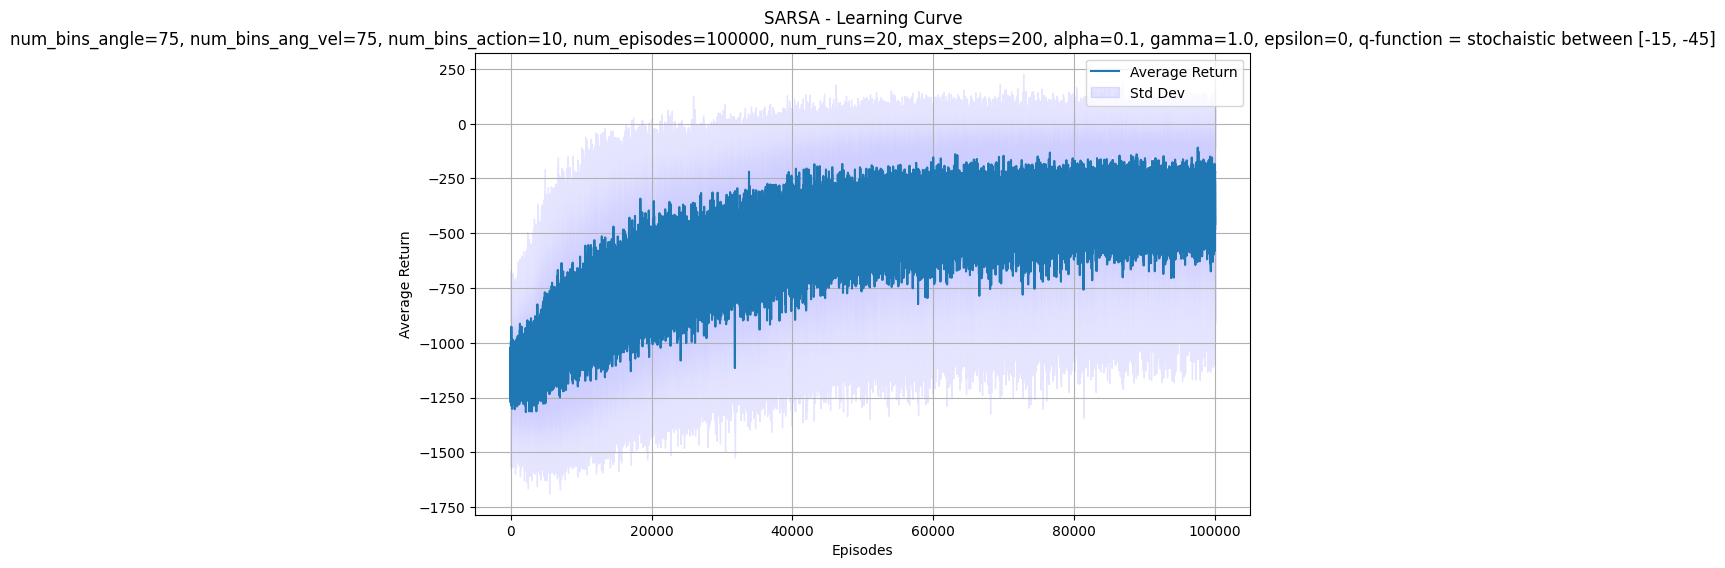

In [252]:
# Define the parameters to display
params = f"num_bins_angle={num_bins_angle}, num_bins_ang_vel={num_bins_ang_vel}, num_bins_action={num_bins_action}, "
params += f"num_episodes={num_episodes}, num_runs={num_runs}, max_steps={max_steps}, "
params += f"alpha={alpha}, gamma={gamma}, epsilon={epsilon}, q-function = stochaistic between [-15, -45]"

# Plot for SARSA
plt.figure(figsize=(10, 6))
plt.plot(range(num_episodes), mean_returns_sarsa, label="Average Return")
plt.fill_between(range(num_episodes),
                 mean_returns_sarsa - std_returns_sarsa,
                 mean_returns_sarsa + std_returns_sarsa,
                 color='blue', alpha=0.1, label="Std Dev")
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title(f"SARSA - Learning Curve\n{params}")
plt.legend()
plt.grid()
plt.show()